## Gaussian Mixture Model Modification
- https://jeffpollock9.github.io/variational-inference-in-pyro/
- https://angusturner.github.io/generative_models/2017/11/03/pytorch-gaussian-mixture-model.html
- Task1: Remove the full guide and estimate all parameters and latent variables (including 'obs' and 'assignment') of the model using the AutoDelta guide.
- Task2: Remove all existing guides and estimate the model using a guide generated from using AutoDiagonalNormal (see example). This is the mean-field variational method, and should give the same answer as Stan's VI estimation.
- Task3: Remove all existing guides and estimate the model using a guide generated from AutoIAFNormal. This is the normalizing flow autoguide generator.

For the latter two, if necessary, add back in the AutoDelta for the global parameters.

In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 276kB 5.0MB/s 
     |████████████████████████████████| 748.9MB 18kB/s 
     |████████████████████████████████| 51kB 17.7MB/s 
  Created wheel for pyro-ppl: filename=pyro_ppl-0.4.1-cp36-none-any.whl size=371731 sha256=0eddbe93ed53db0ae32a0613dd2ce77b379cb6e3a74ef7f1be1edc7bd82c8d6e
  Stored in directory: /root/.cache/pip/wheels/fb/47/97/848e699fb40fc9fd17f421c135cf7bc121dcf3f0c8519e89b2
Successfully built pyro-ppl
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


### Prepare:Variational Inference with Pyro

#### JitTraceGraph_ELBO()

- class JitTraceGraph_ELBO(num_particles=1, max_iarange_nesting=inf, strict_enumeration_warning=True)
  - Bases: pyro.infer.tracegraph_elbo.TraceGraph_ELBO
  - Like TraceGraph_ELBO but uses torch.jit.compile() to compile loss_and_grads().
  - This works only for a limited set of models:
    - Models must have static structure.
    - Models must not depend on any global data (except the param store).
    - All model inputs that are tensors must be passed in via *args.
    - All model inputs that are not tensors must be passed in via *kwargs, and these will be fixed to their values on the first call to loss_and_grads().
- loss_and_grads(model, guide, *args, **kwargs)

In [2]:
import torch
import pyro
import pyro.optim
import pyro.infer
import pyro.distributions as dist
import pyro.contrib.autoguide as autoguide
import numpy as np
import time as tm

pyro.set_rng_seed(42)

N = 2500
P = 8
LEARNING_RATE = 1e-2
NUM_STEPS = 30000
NUM_SAMPLES = 3000

alpha_true = dist.Normal(42.0, 10.0).sample()
beta_true = dist.Normal(torch.zeros(P), 10.0).sample()
sigma_true = dist.Exponential(1.0).sample()

eps = dist.Normal(0.0, sigma_true).sample([N])
x = torch.randn(N, P)
y = alpha_true + x @ beta_true + eps


def model(x, y):
    alpha = pyro.sample("alpha", dist.Normal(0.0, 100.0))
    beta = pyro.sample("beta", dist.Normal(torch.zeros(P), 10.0))
    sigma = pyro.sample("sigma", dist.HalfNormal(10.0))
    mu = alpha + x @ beta
    return pyro.sample("y", dist.Normal(mu, sigma), obs=y)


guide = autoguide.AutoDiagonalNormal(model)
optimiser = pyro.optim.Adam({"lr": LEARNING_RATE})
loss = pyro.infer.JitTraceGraph_ELBO()
svi = pyro.infer.SVI(model, guide, optimiser, loss, num_samples=NUM_SAMPLES)

losses = np.empty(NUM_STEPS)

pyro.clear_param_store()

start = tm.time()

for step in range(NUM_STEPS):
    losses[step] = svi.step(x, y)
    if step % 5000 == 0:
        print(f"step: {step:>5}, ELBO loss: {losses[step]:.2f}")

print(f"\nfinished in {tm.time() - start:.2f} seconds")

step:     0, ELBO loss: -27173.76
step:  5000, ELBO loss: -26447.30
step: 10000, ELBO loss: -15695.45
step: 15000, ELBO loss: 1660.09
step: 20000, ELBO loss: 1655.38
step: 25000, ELBO loss: 1653.51

finished in 53.14 seconds


Text(0, 0.5, 'ELBO loss')

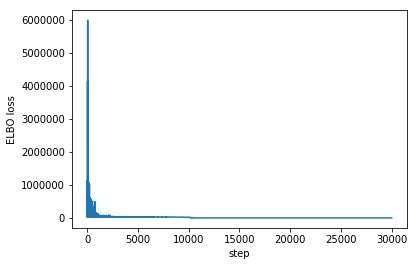

In [3]:
import matplotlib.pyplot as plt

plt.plot(-losses)
plt.xlabel("step")
plt.ylabel("ELBO loss")

Text(0, 0.5, 'ELBO loss')

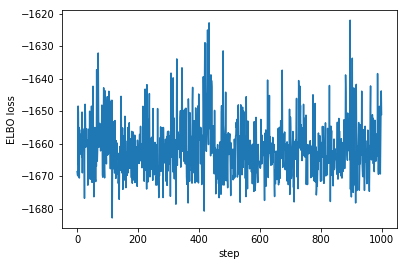

In [4]:
plt.plot(-losses[-1000:])
plt.xlabel("step")
plt.ylabel("ELBO loss")

- The variational parameters (the means and the standard deviations of the factored Gaussians) end up getting stored in the "param store" and look this this:

In [5]:
for key, value in pyro.get_param_store().items():    
    print(f"{key}:\n{value}\n")

auto_loc:
tensor([ 45.3669,   1.2877,   2.3520,   2.3051, -11.2264,  -1.8614,  22.0862,
         -6.3865,   4.6223,  -1.8040], requires_grad=True)

auto_scale:
tensor([0.0032, 0.0038, 0.0037, 0.0032, 0.0039, 0.0039, 0.0032, 0.0033, 0.0032,
        0.0143], grad_fn=<AddBackward0>)



In [6]:
!pip install arviz

     |████████████████████████████████| 1.3MB 4.9MB/s 
     |████████████████████████████████| 4.1MB 42.4MB/s 
     |████████████████████████████████| 307kB 46.7MB/s 


In [7]:
import arviz as az

posterior = svi.run(x, y)
support = posterior.marginal(["alpha", "beta", "sigma"]).support()

data_dict = {k: np.expand_dims(v.detach().numpy(), 0) for k, v in support.items()}
data = az.dict_to_dataset(data_dict)
summary = az.summary(data, round_to=4)[["mean", "sd"]]

print(summary)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

            mean      sd
alpha    45.3671  0.0032
beta[0]   1.2876  0.0037
beta[1]   2.3521  0.0037
beta[2]   2.3051  0.0032
beta[3] -11.2264  0.0040
beta[4]  -1.8614  0.0039
beta[5]  22.0861  0.0032
beta[6]  -6.3864  0.0033
beta[7]   4.6224  0.0032
sigma     0.1646  0.0023


In [8]:
import pandas as pd

true_values = torch.cat([alpha_true.reshape(-1), beta_true, sigma_true.reshape(-1)])
true_names = ["alpha", *[f"beta[{i}]" for i in range(P)], "sigma"]
true_dict = {"names": true_names, "values": true_values}
true_data = pd.DataFrame(true_dict).set_index("names")

print(true_data.round(4))

            values
names             
alpha    45.366901
beta[0]   1.288100
beta[1]   2.344600
beta[2]   2.303300
beta[3] -11.228600
beta[4]  -1.863300
beta[5]  22.082001
beta[6]  -6.380000
beta[7]   4.616600
sigma     0.170900


In [9]:
ELBO_SAMPLES = 100
# re-ran using a larger number of samples in the ELBO calculation. 
# It drastically reduces the number of steps 
# as the extra samples seems to have a big affect on the run time:
NUM_STEPS = 300

guide = autoguide.AutoDiagonalNormal(model)
optimiser = pyro.optim.Adam({"lr": LEARNING_RATE})
loss = pyro.infer.JitTraceGraph_ELBO(ELBO_SAMPLES)
svi = pyro.infer.SVI(model, guide, optimiser, loss)

losses2 = np.empty(NUM_STEPS)

pyro.clear_param_store()

start = tm.time()

for step in range(NUM_STEPS):
    losses2[step] = svi.step(x, y)
    if step % 10 == 0:
        print(f"step: {step:>5}, ELBO loss: {losses[step]:.2f}")

print(f"\nfinished in {tm.time() - start:.2f} seconds")

step:     0, ELBO loss: -27173.76
step:    10, ELBO loss: -225960.30
step:    20, ELBO loss: -91981.62
step:    30, ELBO loss: -61983.91
step:    40, ELBO loss: -27062.07
step:    50, ELBO loss: -60455.68
step:    60, ELBO loss: -287858.34
step:    70, ELBO loss: -27256.19
step:    80, ELBO loss: -60149.79
step:    90, ELBO loss: -69487.65
step:   100, ELBO loss: -117253.12
step:   110, ELBO loss: -27988.85
step:   120, ELBO loss: -209660.78
step:   130, ELBO loss: -221829.00
step:   140, ELBO loss: -125582.86
step:   150, ELBO loss: -34039.57
step:   160, ELBO loss: -100526.39
step:   170, ELBO loss: -52094.48
step:   180, ELBO loss: -61479.11
step:   190, ELBO loss: -88531.58
step:   200, ELBO loss: -98519.19
step:   210, ELBO loss: -29329.11
step:   220, ELBO loss: -276360.94
step:   230, ELBO loss: -88447.78
step:   240, ELBO loss: -47777.77
step:   250, ELBO loss: -79835.84
step:   260, ELBO loss: -30508.73
step:   270, ELBO loss: -32641.59
step:   280, ELBO loss: -194976.41
step:

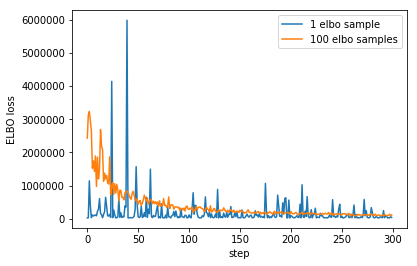

In [10]:
# So looks as we'd expect - with more samples the estimate has less noise
plt.plot(-losses[:NUM_STEPS], label="1 elbo sample")
plt.plot(-losses2, label = f"{ELBO_SAMPLES} elbo samples")
plt.xlabel("step")
plt.ylabel("ELBO loss")
plt.legend()

### Task1: estimate all parameters and latent variables using AutoDelta guide

In [0]:
from __future__ import print_function
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

In [0]:
#  tiny dataset has five points
data = torch.tensor([0., 1., 10., 11., 12.])

# Some concerns here:
# "obs" should NOT appear in the guide chunk since it is for calculating losses
# "assignment" relates to a Categorical distribution in model chunk and is used for indices
# so its int type faces problems with gradients option

In [0]:
K = 2  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

In [0]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

In [15]:
# Have to set initial seed for further sampling

def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_scale', (data.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)]);
    loss = svi.loss(model, global_guide, data)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 7, initial_loss = 25.665584564208984


In [16]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

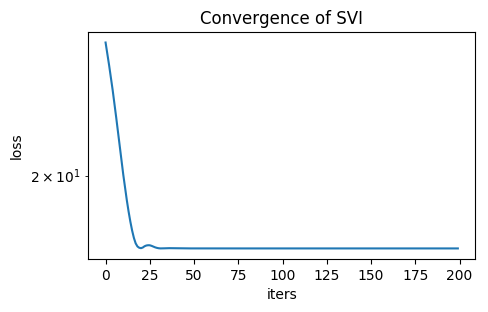

In [17]:
pyplot.figure(figsize=(5,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [18]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.375 0.625]
locs = [ 0.49867362 10.984463  ]
scale = 0.6514336466789246


In [0]:
# Public interface.
# unit_interval = _Interval(0., 1.)

@config_enumerate
def full_guide(data):
    # Global variables.
    with poutine.block(hide_types=["param"]):  # Keep our learned values of global parameters.
        global_guide(data)

    # Local variables.
    with pyro.plate('data', len(data)):
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data), K)/K, constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Categorical(assignment_probs))

In [20]:
optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, full_guide, optim, loss=elbo)

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
svi.loss(model, full_guide, data)  # Initializes param store.
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

In [21]:
for name, value in pyro.get_param_store().named_parameters():
    print(name); print(value)

auto_weights
tensor([-0.9486, -0.4377], requires_grad=True)
auto_scale
tensor(-0.4286, requires_grad=True)
auto_locs
tensor([ 0.4987, 10.9845], requires_grad=True)
assignment_probs
tensor([[ 2.9652, -7.0848],
        [ 2.9634, -7.0771],
        [-7.0725,  2.9623],
        [-7.0817,  2.9645],
        [-7.0880,  2.9660]], requires_grad=True)


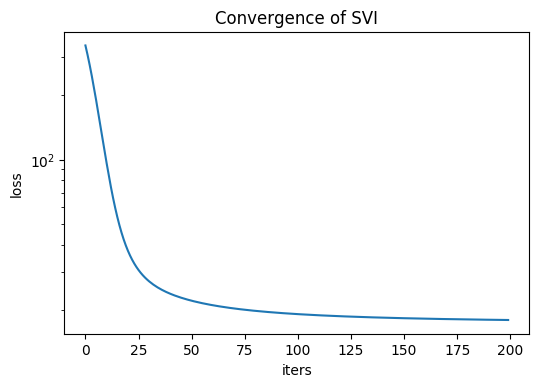

In [22]:
pyplot.figure(figsize=(6,4), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

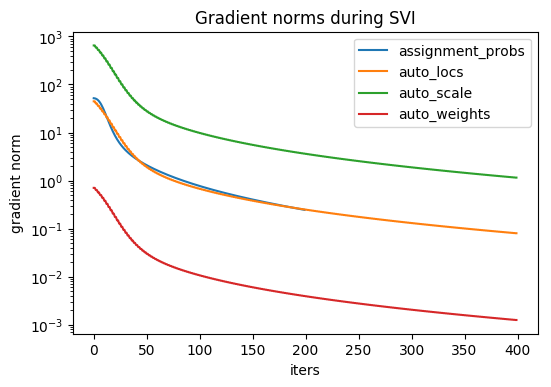

In [23]:
pyplot.figure(figsize=(6,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

### Task2: Remove all existing guides and estimate the model using a guide generated from using AutoDiagonalNormal 

### Feedback and some update on 09/07/2019
- For starters, could you take a look as to why the following changes to the section on "A pre-example from Link above" does not respect the positive constraints on certain values? Basically, I don't understand why mu_scale and sig_scale are negative. 

In [0]:
from pyro.infer import Trace_ELBO, JitTrace_ELBO, TraceEnum_ELBO, JitTraceEnum_ELBO, SVI
from pyro.infer.mcmc import MCMC, NUTS
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.optim import Adam

# class JitTraceEnum_ELBO(num_particles=1, max_iarange_nesting=inf, strict_enumeration_warning=True)
# Bases: pyro.infer.traceenum_elbo.TraceEnum_ELBO
# Like TraceEnum_ELBO but uses pyro.ops.jit.compile() to compile loss_and_grads()

In [25]:
# getattr() Parameters
# The getattr() method takes multiple parameters:
## object - object whose named attribute's value is to be returned
## name - string that contains the attribute's name
## default (Optional) - value that is returned when the named attribute is not found

# example
class Person:
    age = 23
    name = "Adam"

person = Person()
print('The age is:', getattr(person, "age"))
print('The age is:', person.age)

The age is: 23
The age is: 23


#### Distribution class and Constraint class

In [0]:
"""
Do NOT run this chunk
"""
# Add property of the distribution class in Pyro
# https://pytorch.org/docs/stable/_modules/torch/distributions/distribution.html

class Distribution(object):
  
    r"""
    Distribution is the abstract base class for probability distributions.
    """
    
    has_rsample = False
    has_enumerate_support = False
    _validate_args = False
    support = None
    arg_constraints = {}

    @staticmethod
    def set_default_validate_args(value):
        if value not in [True, False]:
            raise ValueError
        Distribution._validate_args = value

    def __init__(self, batch_shape=torch.Size(), event_shape=torch.Size(), validate_args=None):
        self._batch_shape = batch_shape
        self._event_shape = event_shape
        if validate_args is not None:
            self._validate_args = validate_args
        if self._validate_args:
            for param, constraint in self.arg_constraints.items():
                if constraints.is_dependent(constraint):
                    continue  # skip constraints that cannot be checked
                if param not in self.__dict__ and isinstance(getattr(type(self), param), lazy_property):
                    continue  # skip checking lazily-constructed args
                if not constraint.check(getattr(self, param)).all():
                    raise ValueError("The parameter {} has invalid values".format(param))
        super(Distribution, self).__init__()

# Constraint check
class Constraint(object):
  
    """
    Abstract base class for constraints.

    A constraint object represents a region over which a variable is valid,
    e.g. within which a variable can be optimized.
    """
    
    def check(self, value):
        """
        Returns a byte tensor of `sample_shape + batch_shape` indicating
        whether each event in value satisfies this constraint.
        """
        raise NotImplementedErro

### Bayesian inference; How we are able to chase the Posterior
- https://www.ritchievink.com/blog/2019/06/10/bayesian-inference-how-we-are-able-to-chase-the-posterior/

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1720: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Text(0, 0.5, '$\\sigma$')

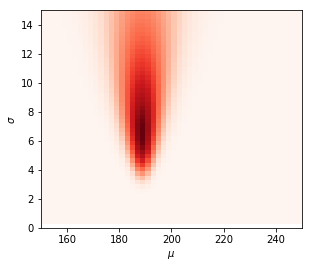

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

lengths = np.array([195, 182])
# lets create a grid of our two parameters
mu_te = np.linspace(150, 250)
sigma_te = np.linspace(0, 15)[::-1]
mm, ss = np.meshgrid(mu_te, sigma_te)  # just broadcasted parameters

likelihood = stats.norm(mm, ss).pdf(lengths[0]) * stats.norm(mm, ss).pdf(lengths[1])
aspect = mm.max() / ss.max() / 3
extent = [mm.min(), mm.max(), ss.min(), ss.max()]
# extent = left right bottom top

plt.imshow(likelihood, cmap='Reds', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

Text(0, 0.5, '$\\sigma$')

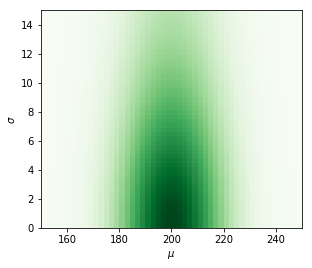

In [27]:
prior = stats.norm(200, 15).pdf(mm) * stats.cauchy(0, 10).pdf(ss)
# visualization
plt.imshow(prior, cmap='Greens', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

Text(0, 0.5, '$\\sigma$')

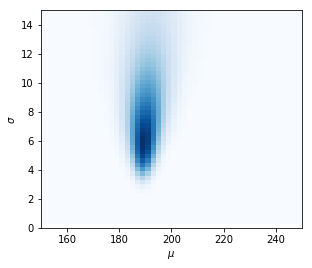

In [28]:
unnormalized_posterior = prior * likelihood
posterior = unnormalized_posterior / np.nan_to_num(unnormalized_posterior).sum()
plt.imshow(posterior, cmap='Blues', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

In [0]:
# https://github.com/pyro-ppl/pyro/issues/1389
# https://pytorch.org/docs/stable/_modules/torch/distributions/half_cauchy.html
# only define the scale parameter in HalfCaucy distribution

# Variational Inference in Pyro
def model():
    # priors
    mu = pyro.sample('mu', dist.Normal(loc=torch.tensor(200.), scale=torch.tensor(15.)))
    sigma = pyro.sample('sigma', dist.HalfCauchy(scale=torch.tensor(10.)))
    # likelihood
    with pyro.plate('plate', size=2):
        pyro.sample(f'obs', dist.Normal(loc=mu, scale=sigma), obs=torch.tensor([195., 185.]))

def guide():
    # variational parameters
    var_mu = pyro.param('var_mu', torch.tensor(180.))
    var_mu_sig = pyro.param('var_mu_sig', torch.tensor(5.), constraint=constraints.positive)
    var_sig = pyro.param('var_sig', torch.tensor(5.))

    # factorized distribution
    pyro.sample('mu', dist.Normal(loc=var_mu, scale=var_mu_sig))
    pyro.sample('sigma', dist.Chi2(var_sig))

In [31]:
pyro.clear_param_store()
pyro.enable_validation(True)
svi = SVI(model, guide, optim=pyro.optim.ClippedAdam({"lr":0.01}), loss=Trace_ELBO())
# do gradient steps
c = 0
for step in range(5000):
  c += 1
  loss = svi.step()
  if step % 200 == 0:
    print("[iteration {:>4}] loss: {:.4f}".format(c, loss))

[iteration    1] loss: 21.0256
[iteration  201] loss: 8.6397
[iteration  401] loss: 16.8888
[iteration  601] loss: 12.9717
[iteration  801] loss: 6.4161
[iteration 1001] loss: 9.8305
[iteration 1201] loss: 8.3449
[iteration 1401] loss: 12.6317
[iteration 1601] loss: 9.1577
[iteration 1801] loss: 9.5381
[iteration 2001] loss: 8.3370
[iteration 2201] loss: 9.1890
[iteration 2401] loss: 7.9361
[iteration 2601] loss: 9.0227
[iteration 2801] loss: 9.6124
[iteration 3001] loss: 7.1890
[iteration 3201] loss: 7.5085
[iteration 3401] loss: 7.3282
[iteration 3601] loss: 8.4288
[iteration 3801] loss: 8.6519
[iteration 4001] loss: 8.6569
[iteration 4201] loss: 8.4980
[iteration 4401] loss: 8.0793
[iteration 4601] loss: 7.4831
[iteration 4801] loss: 8.0537


In [32]:
for name, value in pyro.get_param_store().named_parameters():
    print(name); print(value)

var_mu
tensor(190.2063, requires_grad=True)
var_mu_sig
tensor(1.5864, requires_grad=True)
var_sig
tensor(10.4998, requires_grad=True)


(0, 15.0)

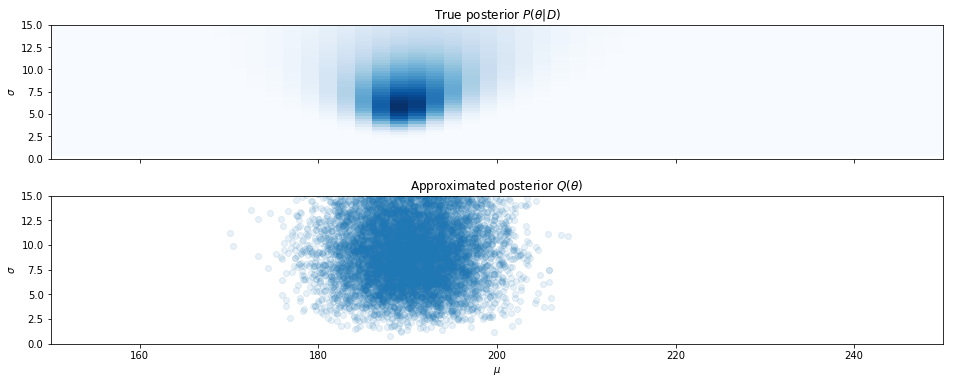

In [33]:
#  initialize our approximated distributions and sample from them
sigma = dist.Chi2(pyro.param('var_sig')).sample((10000,)).numpy()
mu = dist.Normal(pyro.param('var_mu'), pyro.param('var_mu_sig')).sample((10000,)).numpy()

fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (16, 6))
axes[0].imshow(posterior, cmap='Blues', extent=extent, aspect=1)
axes[0].set_ylabel('$\sigma$')
axes[1].scatter(mu, sigma, alpha=0.1)
axes[1].set_ylabel('$\sigma$')
axes[0].set_title('True posterior $P(\\theta|D)$')
axes[1].set_title('Approximated posterior $Q(\\theta)$')
plt.xlabel('$\mu$')
plt.xlim(150, mm.max())
plt.ylim(0, ss.max())

### Modified chunk in previous version (may crash)

- Crash Problem: - https://forum.pyro.ai/t/setting-constraints-and-guides-on-constrained-distributions/742
  - it is failing because the sigma sample in the guide is outside of the support of the sigma distribution in the model. Thus either use a distribution with a positive support eg HalfCauchy or transform it via eg softplus().

In [0]:
# We need to calculate the log_prob of the sample provided in guide based on model func
def elbo(model, guide, *args, **kwargs):
    guide_trace = trace(guide).get_trace(*args, **kwargs)
    model_trace = trace(replay(model, guide_trace)).get_trace(*args, **kwargs)
    elbo = 0.
    for site in model_trace.values():
        if site["type"] == "sample":
            elbo = elbo + site["fn"].log_prob(site["value"]).sum()
    for site in guide_trace.values():
        if site["type"] == "sample":
            elbo = elbo - site["fn"].log_prob(site["value"]).sum()
    return -elbo

In [35]:
# an example for Softplus function
m = torch.nn.Softplus()
input_ = torch.randn(3)
output1 = m(input_)
output2 = m(torch.tensor(-0.5))
print(output1)
print(output2)

tensor([0.6087, 0.2761, 0.4722])
tensor(0.4741)


In [38]:
# https://pytorch.org/docs/master/_modules/torch/distributions/half_normal.html#HalfNormal

from pyro.infer import SVI, JitTraceGraph_ELBO, TraceGraph_ELBO

def model(data):
    mu = pyro.sample("mu", dist.Normal(0., 1.))
    sig = pyro.sample("sig", dist.HalfCauchy(1e-6, 5))
    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.Normal(mu, sig), obs=data)

softplus = torch.nn.Softplus()
def guide(data):
  mu_loc = pyro.param("mu_loc", torch.zeros(1))
  mu_scale = pyro.param("mu_scale", torch.ones(1), constraint=constraints.positive)
  mu = pyro.sample("mu", dist.Normal(mu_loc, mu_scale))
  
  sigma_loc = pyro.param("sig_loc", torch.ones(1), constraint=constraints.positive)
  sigma_scale = pyro.param("sig_scale", torch.ones(1), constraint=constraints.positive)
  sigma = pyro.sample("sig", dist.HalfNormal(sigma_loc, sigma_scale))
  # sigma = pyro.sample("sig", dist.Normal(sigma_loc, sigma_scale))

# data generation and estimation set up
data = dist.Normal(15., 1.5).sample((100,))

pyro.clear_param_store()
# elbo = Trace_ELBO(max_plate_nesting=1)
elbo = TraceGraph_ELBO(5)
svi = SVI(model, guide, Adam({'lr': 0.05, 'betas': [0.8, 0.99]}), elbo)
    
losses = []
for i in range(5000 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    if((i+1) % 500 == 0):
      print("step: {} loss: {:.2f}\n".format(i+1, losses[i]), end='')

step: 500 loss: 87629.98
step: 1000 loss: 1593.16
step: 1500 loss: 4468.05
step: 2000 loss: 26223.83
step: 2500 loss: 550.69
step: 3000 loss: 514.14
step: 3500 loss: 878.14
step: 4000 loss: 717.94
step: 4500 loss: 726.83
step: 5000 loss: 762.73


In [39]:
for name, value in pyro.get_param_store().named_parameters():
    print(name); print(value)

mu_loc
tensor([6.9631], requires_grad=True)
mu_scale
tensor([1.2465], requires_grad=True)
sig_loc
tensor([6.1257], requires_grad=True)
sig_scale
tensor([0.], requires_grad=True)


### An example from Link below
- https://pyro.ai/examples/jit.html

### Prepare for AutoDiagonalNormal 
- This implementation of AutoContinuous uses a Normal distribution with a diagonal covariance matrix to construct a guide over the entire latent space.

In [0]:
"""
Do NOT run this chunk
"""
class AutoDiagonalNormal(AutoContinuous):
    """
    This implementation of :class:`AutoContinuous` uses a Normal distribution
    with a diagonal covariance matrix to construct a guide over the entire
    latent space. The guide does not depend on the model's ``*args, **kwargs``.

    Usage::

        guide = AutoDiagonalNormal(model)
        svi = SVI(model, guide, ...)

    By default the mean vector is initialized to zero and the scale is
    initialized to the identity.  To change this default behavior the user
    should call :func:`pyro.param` before beginning inference, e.g.::
        latent_dim = 10
        pyro.param("auto_loc", torch.randn(latent_dim))
        pyro.param("auto_scale", torch.ones(latent_dim), constraint=constraints.positive)
    """
    def sample_latent(self, *args, **kwargs):
        """
        Samples the (single) diagnoal normal latent used in the auto guide.
        """
        loc = pyro.param("{}_loc".format(self.prefix), lambda: torch.zeros(self.latent_dim))
        scale = pyro.param("{}_scale".format(self.prefix), lambda: torch.ones(self.latent_dim), constraint=constraints.positive)
        return pyro.sample("_{}_latent".format(self.prefix), dist.Normal(loc, scale).independent(1), infer={"is_auxiliary": True})

    def _loc_scale(self, *args, **kwargs):
        loc = pyro.param("{}_loc".format(self.prefix))
        scale = pyro.param("{}_scale".format(self.prefix))
        return loc, scale

In [0]:
"""
Do NOT run this chunk
"""
class AutoContinuous(AutoGuide):
    """
    Base class for implementations of continuous-valued Automatic
    Differentiation Variational Inference [1].

    Each derived class implements its own :meth:`sample_latent` method.
    Assumes model structure and latent dimension are fixed, and all latent variables are continuous.
    """
    
    def _setup_prototype(self, *args, **kwargs):
        super(AutoContinuous, self)._setup_prototype(*args, **kwargs)
        self._unconstrained_shapes = {}
        self._cond_indep_stacks = {}
        for name, site in self.prototype_trace.nodes.items():
            if site["type"] != "sample" or site["is_observed"]:
                continue
            # Collect the shapes of unconstrained values.
            # These may differ from the shapes of constrained values.
            self._unconstrained_shapes[name] = biject_to(site["fn"].support).inv(site["value"]).shape
            # Collect independence contexts.
            self._cond_indep_stacks[name] = site["cond_indep_stack"]
        self.latent_dim = sum(_product(shape) for shape in self._unconstrained_shapes.values())
        if self.latent_dim == 0:
            raise RuntimeError('{} found no latent variables; Use an empty guide instead'.format(type(self).__name__))

    def sample_latent(self, *args, **kwargs):
        """
        Samples an encoded latent given the same ``*args, **kwargs`` as the
        base ``model``.
        """
        raise NotImplementedError

    def _unpack_latent(self, latent):
        """
        Unpacks a packed latent tensor, iterating over tuples of the form::
            (site, unconstrained_value)
        """
        pos = 0
        for name, site in self.prototype_trace.nodes.items():
            if site["type"] == "sample" and not site["is_observed"]:
                unconstrained_shape = self._unconstrained_shapes[name]
                size = _product(unconstrained_shape)
                unconstrained_value = latent[pos:pos + size].view(unconstrained_shape)
                yield site, unconstrained_value
                pos += size
        assert pos == len(latent)

    def __call__(self, *args, **kwargs):
        """
        An automatic guide with the same ``*args, **kwargs`` as the base ``model``.
        :return: A dict mapping sample site name to sampled value.
        :rtype: dict
        """
        # if we've never run the model before, do so now so we can inspect the model structure
        if self.prototype_trace is None:
            self._setup_prototype(*args, **kwargs)

        latent = self.sample_latent(*args, **kwargs)
        iaranges = self._create_iaranges()

        # unpack continuous latent samples
        result = {}
        for site, unconstrained_value in self._unpack_latent(latent):
            name = site["name"]
            transform = biject_to(site["fn"].support)
            value = transform(unconstrained_value)
            log_density = transform.inv.log_abs_det_jacobian(value, unconstrained_value)
            log_density = sum_rightmost(log_density, log_density.dim() - value.dim() + site["fn"].event_dim)
            delta_dist = dist.Delta(value, log_density=log_density, event_dim=site["fn"].event_dim)

            with ExitStack() as stack:
                for frame in self._cond_indep_stacks[name]:
                    stack.enter_context(iaranges[frame.name])
                result[name] = pyro.sample(name, delta_dist)

        return result

    def _loc_scale(self, *args, **kwargs):
        """
        :returns: a tuple ``(loc, scale)`` used by :meth:`median` and :meth:`quantiles`
        """
        raise NotImplementedError

    def median(self, *args, **kwargs):
        """
        Returns the posterior median value of each latent variable.
        :return: A dict mapping sample site name to median tensor.
        :rtype: dict
        """
        loc, scale = self._loc_scale(*args, **kwargs)
        return {site["name"]: biject_to(site["fn"].support)(unconstrained_value)
                for site, unconstrained_value in self._unpack_latent(loc)}

    def quantiles(self, quantiles, *args, **kwargs):
        """
        Returns posterior quantiles each latent variable. Example::
            print(guide.quantiles([0.05, 0.5, 0.95]))

        :param quantiles: A list of requested quantiles between 0 and 1.
        :type quantiles: torch.Tensor or list
        :return: A dict mapping sample site name to a list of quantile values.
        :rtype: dict
        """
        loc, scale = self._loc_scale(*args, **kwargs)
        quantiles = loc.new_tensor(quantiles).unsqueeze(-1)
        latents = dist.Normal(loc, scale).icdf(quantiles)
        result = {}
        for latent in latents:
            for site, unconstrained_value in self._unpack_latent(latent):
                result.setdefault(site["name"], []).append(biject_to(site["fn"].support)(unconstrained_value))
        return result

In [75]:
def model(data):
    loc = pyro.sample("loc", dist.Normal(0., 10.))
    scale = pyro.sample("scale", dist.LogNormal(0., 3.))
    with pyro.plate("data", data.size(0)):
        pyro.sample("obs", dist.Normal(loc, scale), obs=data)

guide = AutoDiagonalNormal(model)
data = dist.Normal(0.5, 5.).sample((3000,))

pyro.clear_param_store()
elbo = Trace_ELBO(10)
# elbo = JitTrace_ELBO()
svi = SVI(model, guide, Adam({'lr': 0.01}), elbo)

losses = []
for i in range(5000 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    if((i+1) % 500 == 0):
      print("step: {} loss: {:.2f}\n".format(i+1, losses[i]), end='')

step: 500 loss: 10548.78
step: 1000 loss: 9516.16
step: 1500 loss: 9539.84
step: 2000 loss: 9425.46
step: 2500 loss: 9590.03
step: 3000 loss: 9234.77
step: 3500 loss: 9193.51
step: 4000 loss: 9161.59
step: 4500 loss: 9175.01
step: 5000 loss: 9164.18


In [76]:
for name, value in pyro.get_param_store().named_parameters():
    print(name); print(value)

auto_loc
tensor([0.4670, 1.6348], requires_grad=True)
auto_scale
tensor([-1.7766, -2.1114], requires_grad=True)


#### Use AutoDiagonalNormal to estimate global variables

In [0]:
# recover the tiny five points set
data = torch.tensor([0., 1., 10., 11., 12.])

In [0]:
K = 2 # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
        
    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

# AutoDiagonalNormal
# uses a Normal distribution with a diagonal covariance matrix to 
# construct a guide over the entire latent space.
global_guide_ADN = AutoDiagonalNormal(poutine.block(model, expose=['weights', 'locs', 'scale']))

In [44]:
optim = pyro.optim.Adam({'lr': 0.35, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide_ADN, optim, loss=elbo)

def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_scale', (data.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)]);
    loss = svi.loss(model, global_guide_ADN, data)
    return loss
  
 # Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(2000 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    if((i+1) % 100 == 0):
      print("step: {} loss: {:.2f}\n".format(i+1, losses[i]), end='')

seed = 5, initial_loss = 16.371784210205078
step: 100 loss: 28.50
step: 200 loss: 49.38
step: 300 loss: 26.30
step: 400 loss: 47.53
step: 500 loss: 24.14
step: 600 loss: 27.83
step: 700 loss: 34.80
step: 800 loss: 26.91
step: 900 loss: 22.59
step: 1000 loss: 21.91
step: 1100 loss: 24.30
step: 1200 loss: 22.82
step: 1300 loss: 17.63
step: 1400 loss: 18.55
step: 1500 loss: 18.13
step: 1600 loss: 19.18
step: 1700 loss: 27.68
step: 1800 loss: 18.96
step: 1900 loss: 22.28
step: 2000 loss: 22.85


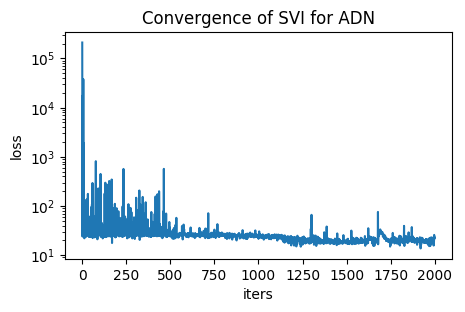

In [45]:
pyplot.figure(figsize=(5,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI for ADN');

In [46]:
map_estimates = global_guide_ADN(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.22644757 0.7735524 ]
locs = [ 0.38750213 10.815302  ]
scale = 1.8827927112579346


In [0]:
@config_enumerate
def full_guide_ADN(data):
    # Global variables.
    with poutine.block(hide_types=["param"]):  # Keep our learned values of global parameters.
        global_guide_ADN(data)

    # Local variables.
    with pyro.plate('data', len(data)):
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data), K)/K, constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Categorical(assignment_probs))

In [48]:
optim = pyro.optim.Adam({'lr': 0.001, 'betas': [0.9, 0.999]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, full_guide_ADN, optim, loss=elbo)

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
svi.loss(model, full_guide_ADN, data)  # Initializes param store.
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(2000 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    if((i+1) % 50 == 0):
      print("step: {} loss: {:.2f}\n".format(i+1, losses[i]), end='')

step: 50 loss: 51.44
step: 100 loss: 31.48
step: 150 loss: 31.37
step: 200 loss: 41.07
step: 250 loss: 62.42
step: 300 loss: 35.42
step: 350 loss: 49.27
step: 400 loss: 55.26
step: 450 loss: 44.14
step: 500 loss: 56.07
step: 550 loss: 33.80
step: 600 loss: 36.23
step: 650 loss: 88.12
step: 700 loss: 46.46
step: 750 loss: 77.38
step: 800 loss: 49.71
step: 850 loss: 46.09
step: 900 loss: 40.44
step: 950 loss: 48.13
step: 1000 loss: 42.09
step: 1050 loss: 46.25
step: 1100 loss: 40.77
step: 1150 loss: 41.06
step: 1200 loss: 36.88
step: 1250 loss: 36.60
step: 1300 loss: 40.99
step: 1350 loss: 35.17
step: 1400 loss: 46.31
step: 1450 loss: 44.79
step: 1500 loss: 48.10
step: 1550 loss: 28.91
step: 1600 loss: 30.35
step: 1650 loss: 34.28
step: 1700 loss: 39.16
step: 1750 loss: 38.18
step: 1800 loss: 32.00
step: 1850 loss: 30.68
step: 1900 loss: 37.82
step: 1950 loss: 34.96
step: 2000 loss: 33.05


In [49]:
# two dimensional weights + one dimensional scale and loc
for name, value in pyro.get_param_store().named_parameters():
    print(name); print(value)

auto_weights
tensor([-0.6931, -0.6931], requires_grad=True)
auto_scale
tensor(-1.4232, requires_grad=True)
auto_locs
tensor([11.,  1.], requires_grad=True)
auto_loc
tensor([-0.7278,  0.7378, -0.0228, 10.8749], requires_grad=True)
assignment_probs
tensor([[ 1.3004, -1.7483],
        [ 1.2911, -1.7326],
        [-1.7750,  1.3132],
        [-1.7815,  1.3176],
        [-1.7859,  1.3207]], requires_grad=True)


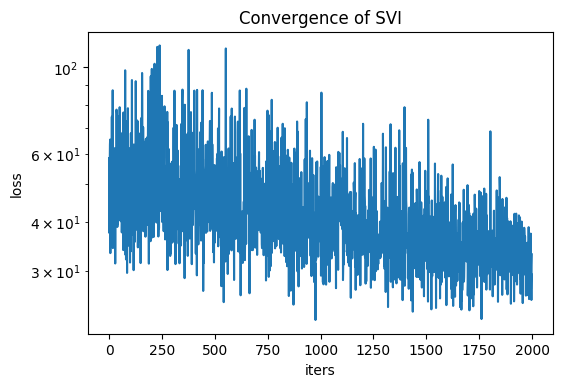

In [50]:
pyplot.figure(figsize=(6,4), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

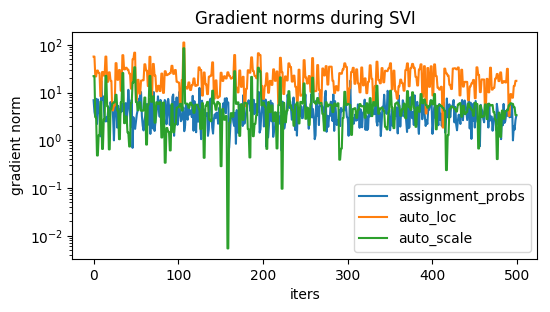

In [51]:
pyplot.figure(figsize=(6,3), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms[-500:], label=name)
    
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

### Task3: Estimate the model using a guide generated from AutoIAFNormal

- AutoIAFNormal
  - class AutoIAFNormal(model, hidden_dim=None, prefix='auto')
    - Bases: pyro.contrib.autoguide.AutoContinuous
    - This implementation of AutoContinuous uses a Diagonal Normal distribution transformed via a InverseAutoregressiveFlow to construct a guide over the entire latent space.
  - Usage:
    - guide = AutoIAFNormal(model, hidden_dim=latent_dim)
    - svi = SVI(model, guide, ...)
  - Parameters:	
    - model (callable) – a generative model
    - hidden_dim (int) – number of hidden dimensions in the IAF
      -  if self.hidden_dim is None, self.hidden_dim = self.latent_dim
    - prefix (str) – a prefix that will be prefixed to all param internal sites

#### A Pre-introduction for Diagonal Normal distribution transformed via a InverseAutoregressiveFlow
- Variational Autoencoder: http://bjlkeng.github.io/posts/variational-autoencoders/
- http://bjlkeng.github.io/posts/variational-autoencoders-with-inverse-autoregressive-flows/

- train the decoder i.e. the generative model for example, 
  - We have our latent diagonal Gaussian variables, followed by a deterministic high-capacity model (i.e. deep net), which then outputs the parameters for our output variables shown below:

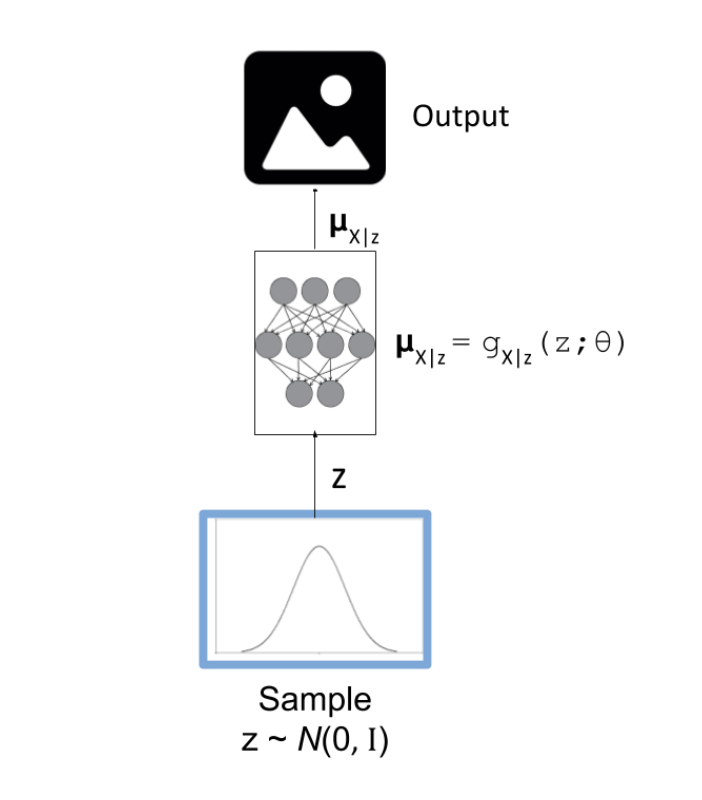

In [52]:
from IPython.display import Image
Image("Generative model component of VAE.png", width=300)

- use "directed" sampling to a pick point z using our encoder (or posterior) network such that x is much more likely to occur:
  - Left: A naive implementation of an autoencoder without the reparameterization trick. 
  - Right: A vanilla variational autoencoder with the "reparameterization trick" 

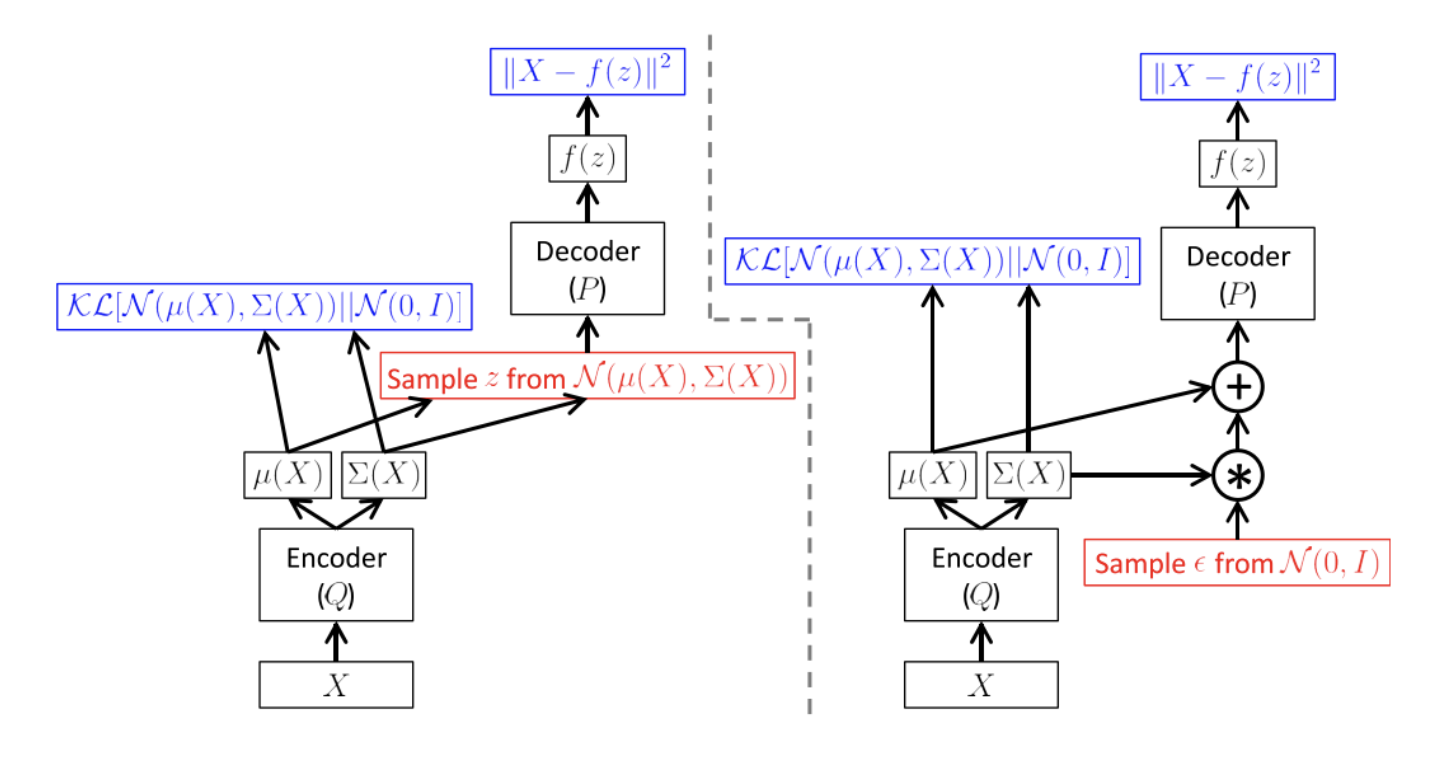

In [53]:
Image("VAE Structure.png", width=600)

#### Normalizing Flows for Variational Inference

- The normalizing flow can be thought of as a sequence of expansions or contractions on the initial density, allowing for things such as multi-modal distributions (something we can't do with a basic Gaussian). 
- Additionally, it allows us to have complex relationships between the variables instead of the independence we assume with our diagonal Gaussians. The trick then is to pick a transformation ft that gives us the flexibility, but more importantly is easy to compute because we want to use this in a VAE setup.

#### Inverse Autoregressive Transformations
- Autoregressive transform is one where given a sequence of variables y={yi},i=0...D, each variable is dependent only on previously indexed variables i.e. yi=fi(y0:i−1).
- Autoregressive autoencoders take advantage of this property by constructing an extension of a vanilla (non-variational) autoencoder that can estimate distributions (whereas the regular one doesn't have a direct probabilistic interpretation).
- Transform any vector: this is shown on the left hand side where we take a x vector and transform it to a y vector through Gaussian version. 
  - Since we have to perform sequential computations, thus making it too slow for our intended purpose of use in a normalizing flow. 
  - The inverse version is on the right hand side: since μ,σ have no dependence on the current or latter variables in our sequence, the Jacobian is lower triangular with a simple diagonal. The determinant of a triangular matrix is the product of its diagonals, this gives us our final result for the log determinant which is incredibly simple to compute.

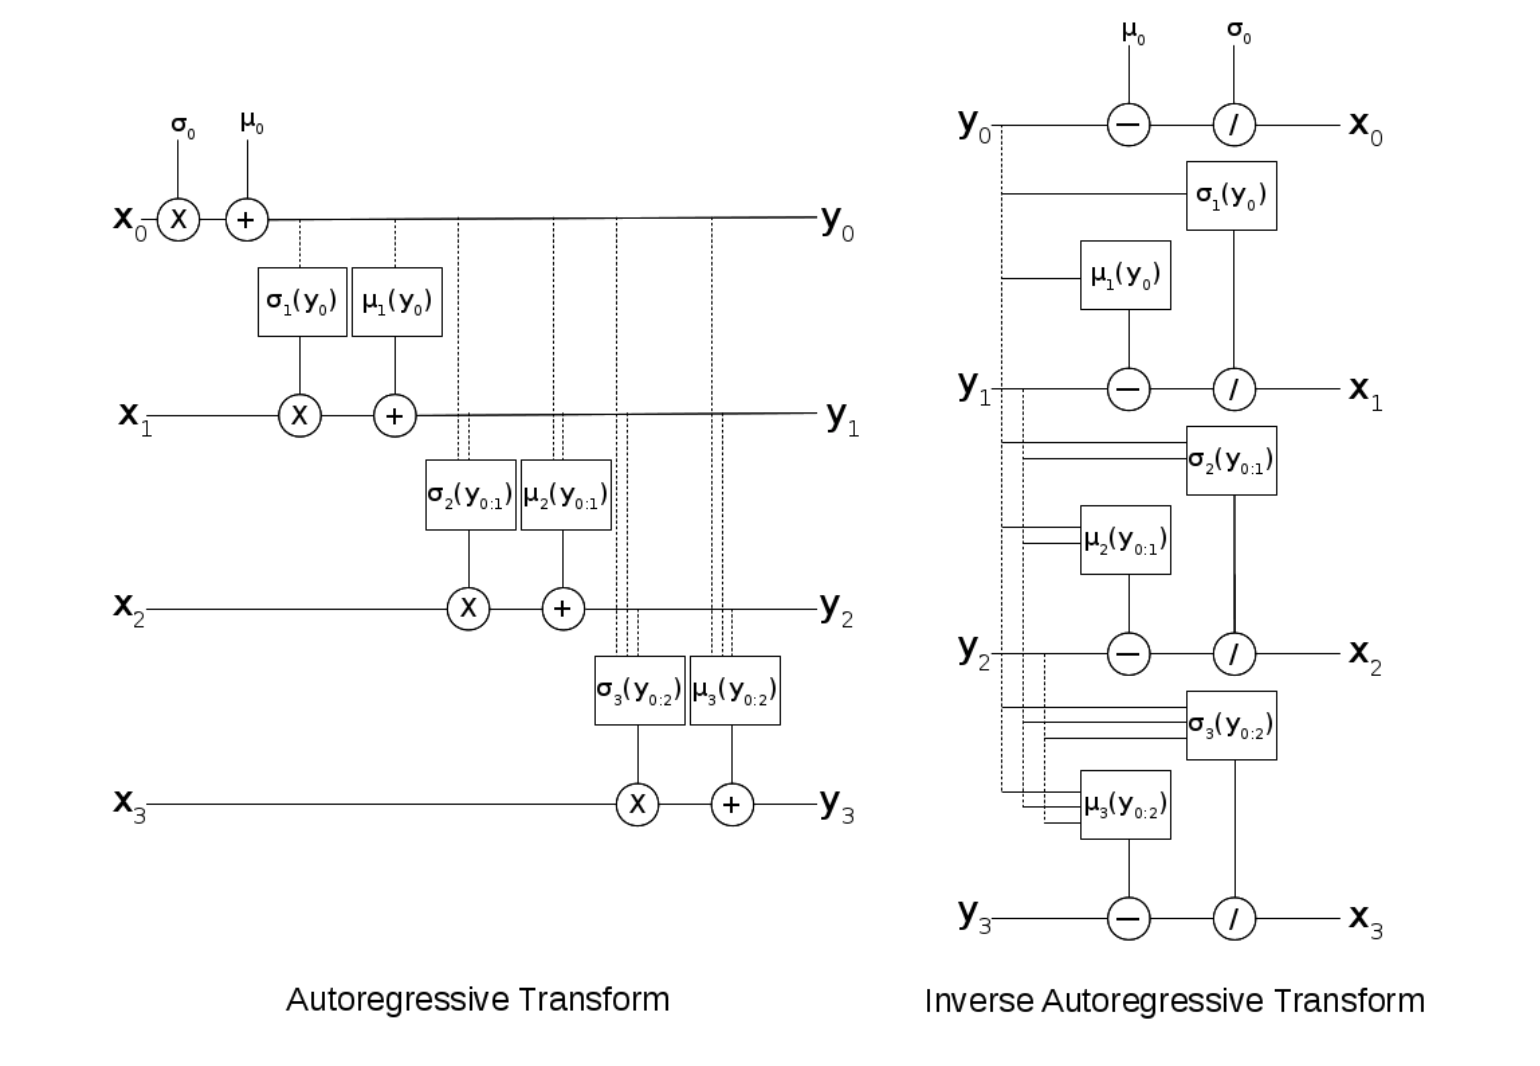

In [54]:
Image("Gaussian version of AT and IAT.png", width=600)

#### Inverse Autoregressive Flows
- Show a depiction of adding several IAF transforms to a variational encoder below: (Left) An Inverse Autoregressive Flow (IAF) transforming basic posterior of an variational encoder(guide) to more complex posterior through multiple IAF transforms.(Right) A single IAF transform.
  - Two things to note: 
    - (1) a context h is additionally generated
    - (2) the IAF step only involves multiplication and addition
- Improved Variational Inference with Inverse Autoregressive Flow: https://arxiv.org/pdf/1606.04934.pdf

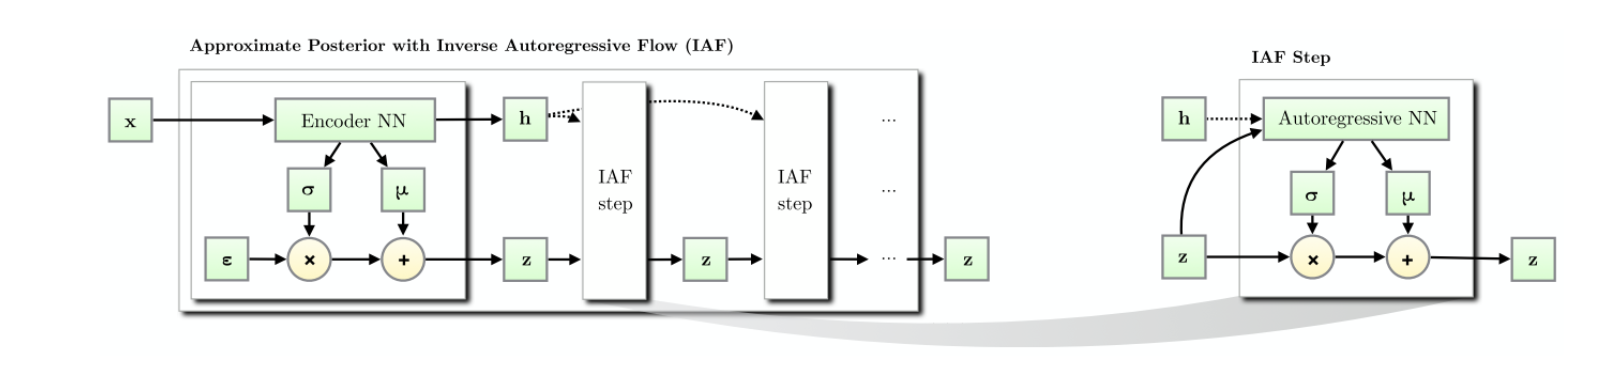

In [55]:
Image("IAF structure.png", width=800)

In [0]:
# if self.latent_dim == 1:
#             raise ValueError('latent dim = 1. Consider using AutoDiagonalNormal instead')
#         if self.hidden_dim is None:
#             self.hidden_dim = self.latent_dim


from pyro.contrib.autoguide import AutoIAFNormal
guide = AutoIAFNormal(poutine.block(model, expose=['weights', 'locs', 'scale']))

In [57]:
pyro.clear_param_store()

optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.8, 0.99]})
# TraceEnum_ELBO(ELBO)
# A trace implementation of ELBO-based SVI that supports enumeration over discrete sample sites.
elbo = TraceEnum_ELBO(100)
svi = SVI(model, guide, optim, loss=elbo)

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
svi.loss(model, guide, data)  # Initializes param store.
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(500 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 200 else '\n', end='')


.......................................................................................................................................................................................................
.......................................................................................................................................................................................................
...................................................................................................

In [58]:
for name, value in pyro.get_param_store().named_parameters():
    print(name); print(value)

auto_iaf$$$arn.layers.0.weight
Parameter containing:
tensor([[-0.4680, -0.4163, -0.2171, -0.2630],
        [-0.4667,  0.3878,  0.2983,  0.1494],
        [-0.0695,  0.4112, -0.2021,  0.7013],
        [ 0.0161, -0.3351, -0.4280, -0.7285]], requires_grad=True)
auto_iaf$$$arn.layers.0.bias
Parameter containing:
tensor([0.6078, 0.4802, 0.4840, 0.2024], requires_grad=True)
auto_iaf$$$arn.layers.1.weight
Parameter containing:
tensor([[ 2.2297, -7.4994,  0.7276,  0.4153],
        [ 1.0816,  0.2085,  0.3311,  0.3864],
        [ 5.1731,  1.1646,  0.4131,  0.1161],
        [ 1.8626,  0.1054, -0.4994, -0.1970],
        [ 0.4335, -0.7179,  0.6462,  0.3768],
        [ 0.0739, -0.3691, -0.1824, -0.3013],
        [ 0.0169,  1.4330,  0.1342,  0.4475],
        [ 0.6593, -0.1600, -0.4704, -0.1081]], requires_grad=True)
auto_iaf$$$arn.layers.1.bias
Parameter containing:
tensor([ 2.3114,  0.6058,  2.8870,  1.6707,  0.3002, -0.7194,  0.7056,  1.1430],
       requires_grad=True)


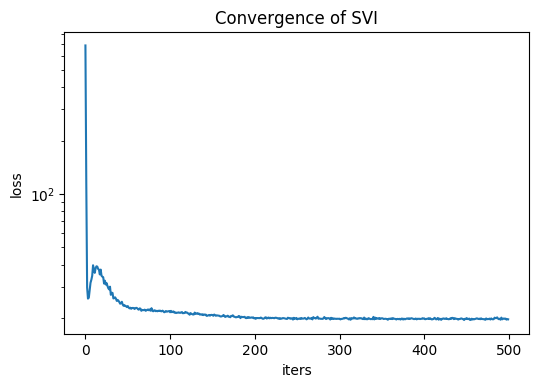

In [59]:
pyplot.figure(figsize=(6,4), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [60]:
# specify the hidden_dimensio to be 5 instead of default 4
guide = AutoIAFNormal(poutine.block(model, expose=['weights', 'locs', 'scale']), hidden_dim=5)

pyro.clear_param_store()

optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.8, 0.99]})
# TraceEnum_ELBO(ELBO)
# A trace implementation of ELBO-based SVI that supports enumeration over discrete sample sites.
elbo = TraceEnum_ELBO(100)
svi = SVI(model, guide, optim, loss=elbo)

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
svi.loss(model, guide, data)  # Initializes param store.
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(500 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 200 else '\n', end='')


.......................................................................................................................................................................................................
.......................................................................................................................................................................................................
...................................................................................................

In [61]:
for name, value in pyro.get_param_store().named_parameters():
    print(name); print(value)

auto_iaf$$$arn.layers.0.weight
Parameter containing:
tensor([[ 0.4637, -0.2018,  0.0960,  0.0076],
        [-0.1920, -0.2628, -0.3955, -0.3829],
        [ 0.0241,  0.4899,  0.4916,  0.1548],
        [-0.1033,  0.4965,  0.1048,  0.3364],
        [ 0.4277, -0.4469,  0.0255, -0.2581]], requires_grad=True)
auto_iaf$$$arn.layers.0.bias
Parameter containing:
tensor([-0.6355,  0.6298, -0.7494, -1.2697,  1.2408], requires_grad=True)
auto_iaf$$$arn.layers.1.weight
Parameter containing:
tensor([[ 1.2268e+00, -1.0657e-01,  2.2605e-01, -1.5501e-01, -3.4134e-01],
        [ 4.6428e-01,  3.8626e-03,  6.9508e-01,  1.0421e-01, -9.7001e-02],
        [ 1.0232e+00,  2.4201e+00,  1.0074e+00,  5.5183e-01,  1.8792e+00],
        [ 4.9581e-01,  4.5125e+00,  4.9506e-01, -1.2293e-01,  1.9978e-01],
        [ 1.1948e+00, -4.2156e-01, -7.6763e-02, -1.7376e-01, -3.8281e-01],
        [-7.3349e-01,  6.1492e-02, -7.4917e-01,  1.7131e-03,  4.8693e-02],
        [ 3.8616e-01,  8.7895e-01,  9.9210e-03, -6.1378e-01, -2.4719

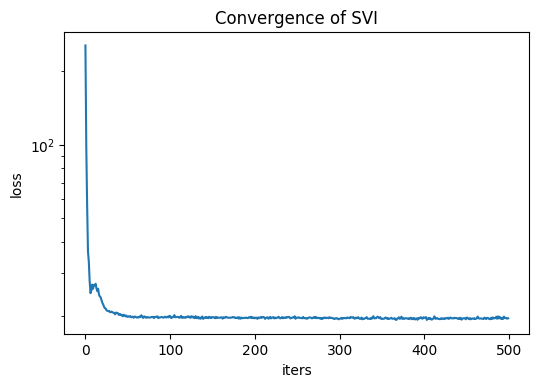

In [62]:
pyplot.figure(figsize=(6,4), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');